In [43]:
from IPython.display import display, Javascript

def restart_kernel():
    display(Javascript('IPython.notebook.kernel.restart()'))

restart_kernel()

<IPython.core.display.Javascript object>

In [44]:
from keras.backend import clear_session
clear_session()

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm, ensemble, linear_model
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, GaussianNoise
from keras.optimizers import SGD
#from keras.utils import np_utils
#from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings("ignore")
seed = 1234
np.random.seed(seed)

In [46]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [47]:
import os
# Configurar TensorFlow para usar la GPU 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Establecer la ruta de CUDA si es necesario
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"

# Preprocesamiento de Datos

In [48]:
# Carga de datos
DATA_PATH = '/data/sespinoza/objetivo1/Paper-Assesment/'
data_original = pd.read_csv(DATA_PATH + 'lihc_mapped.csv', header=0, index_col=0, sep=',', encoding='utf-8')
data_peru = pd.read_csv(DATA_PATH + 'normalized_expression_mapped_peru.csv', header=0, index_col=0, sep=',', encoding='utf-8')

In [49]:
#cuenta los nulos
print(data_original.isnull().sum().sum())
print(data_peru.isnull().sum().sum())

19375
0


In [50]:
#borra los nulos
data_original = data_original.dropna()
data_peru = data_peru.dropna()

In [51]:
data_original.head()

,TCGA.FV.A3I0.01A.11R.A22L.07,TCGA.DD.A3A6.11A.11R.A22L.07,TCGA.DD.A3A6.01A.11R.A22L.07,TCGA.BD.A3ER.01A.11R.A213.07,TCGA.CC.5261.01A.01R.A131.07,TCGA.DD.AAVZ.01A.11R.A41C.07,TCGA.DD.AADN.01A.11R.A41C.07,TCGA.DD.A1EB.01A.11R.A131.07,TCGA.LG.A9QD.01A.11R.A38B.07,TCGA.G3.A25T.01A.11R.A16W.07,...,TCGA.DD.AADY.01A.11R.A41C.07,TCGA.BW.A5NO.01A.11R.A27V.07,TCGA.CC.A7IJ.01A.11R.A33R.07,TCGA.2Y.A9H8.01A.11R.A39D.07,TCGA.BC.A10X.01A.11R.A131.07,TCGA.DD.A3A2.11A.11R.A213.07,TCGA.DD.A3A2.01A.11R.A213.07,TCGA.CC.A5UD.01A.11R.A28V.07,TCGA.BC.A10W.11A.11R.A131.07,hgnc_symbol
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,81.8287,15.8806,4.6169,14.5263,31.3123,39.2772,7.5592,11.2804,18.9790,25.0290,...,19.3421,33.9481,14.8868,40.7063,18.7204,16.0545,22.5661,12.8119,20.3076,TSPAN6
ENSG00000000005,0.0000,0.0000,1.3409,0.0000,0.0000,0.0000,0.0270,0.0668,0.1473,0.0000,...,0.0000,0.0541,0.2324,0.0302,0.2221,0.0770,0.0383,0.1321,0.0129,TNMD
ENSG00000000419,26.1408,8.1109,6.1824,11.3076,46.9221,20.1246,10.2282,18.5906,15.5947,23.8308,...,19.1182,56.6616,19.8273,55.9421,15.9864,14.9355,15.9312,35.2481,15.3580,DPM1
ENSG00000000457,1.7541,0.4566,0.7849,1.2436,4.2047,3.0923,0.2372,2.9764,1.4397,1.0744,...,4.6297,1.2529,1.0602,1.9141,1.2664,0.9934,1.1875,1.7099,0.7651,SCYL3
ENSG00000000460,0.4916,0.1053,0.1165,0.3539,2.2424,1.1239,0.0600,0.2840,0.2883,0.2801,...,1.5588,0.5083,2.5788,1.3405,0.5890,0.1251,0.1704,1.6449,0.2580,FIRRM


In [52]:
data_peru.head()

,GSM4043276_HCC004_HTA_2_0.CEL,GSM4043277_HCC011_HTA_2_0.CEL,GSM4043278_HCC013_HTA_2_0.CEL,GSM4043279_HCC015_HTA_2_0.CEL,GSM4043280_HCC016_HTA_2_0.CEL,GSM4043281_HCC025_HTA_2_0.CEL,GSM4043282_HCC026_HTA_2_0.CEL,GSM4043283_HCC034_HTA_2_0.CEL,GSM4043284_HCC047_HTA_2_0.CEL,GSM4043285_HCC054_HTA_2_0.CEL,...,GSM4043336_NTL121_HTA_2_0.CEL,GSM4043337_NTL173_HTA_2_0.CEL,GSM4043338_NTL188_HTA_2_0.CEL,GSM4043339_NTL190_HTA_2_0.CEL,GSM4043340_NTL191_HTA_2_0.CEL,GSM4043341_NTL192_HTA_2_0.CEL,GSM4043342_NTL193_HTA_2_0.CEL,GSM4043343_NTL200_HTA_2_0.CEL,GSM4043344_NTL201_HTA_2_0.CEL,GeneSymbol
TC01000001.hg.1,5.556382,5.385476,5.582431,5.321239,5.580150,5.090377,5.543542,5.815775,5.781128,5.462648,...,5.747558,5.685633,5.678107,5.479305,5.159973,5.572072,5.586533,5.509569,5.263971,DDX11L1
TC01000003.hg.1,3.522511,3.011026,3.754522,3.216142,3.343459,3.151042,3.232807,3.496659,3.271508,3.475425,...,3.641678,3.554388,3.807339,3.292701,3.069621,3.794532,3.673249,3.423120,3.463470,OR4F5
TC01000005.hg.1,8.388213,8.461633,8.107028,8.165957,8.615982,8.331395,8.491633,8.543905,8.646759,8.200830,...,8.313295,8.007746,8.127470,8.079236,8.439039,8.140706,8.413719,8.269379,8.615382,LINC01001
TC01000007.hg.1,11.313075,11.423049,11.083901,11.134547,11.388560,11.209667,11.249790,11.319392,11.483748,11.555652,...,11.500850,10.496035,11.170733,10.906176,11.196305,11.003916,11.591072,11.292875,11.805233,LINC01061
TC01000009.hg.1,3.510059,3.054648,3.632833,3.064161,3.315992,2.796682,3.583861,2.924338,3.181977,2.668511,...,3.061490,3.128445,3.478542,3.024672,2.822522,3.299731,2.986613,3.001979,3.001183,OR4F29


In [53]:
#borra duplicados
data_original = data_original.drop_duplicates(subset='hgnc_symbol', keep='first')
data_peru = data_peru.drop_duplicates(subset='GeneSymbol', keep='first')

In [54]:
data_original.shape, data_peru.shape

((40894, 425), (23913, 70))

In [55]:
data_original.set_index('hgnc_symbol', inplace=True)
data_peru.set_index('GeneSymbol', inplace=True)

In [56]:
# Función para determinar el tipo de muestra rna seq
def determine_sample_type(sample_name):
    parts = sample_name.split('.')
    if len(parts) > 3:
        sample_code = parts[3][:2]
        if sample_code == '01' or sample_code == '02':
            return 'cancer'
        elif sample_code == '11':
            return 'healthy'
    return 'unknown'


In [57]:
import pandas as pd

sample_names = data_original.columns
# Aplicar la función a los nombres de las muestras
labels_rna = [determine_sample_type(name) for name in sample_names]
# Mostrar las etiquetas asignadas
print(labels_rna)

['cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'healthy', 'cancer', 'cancer', 'cancer', '

In [58]:
labels_ma = ['cancer' if 'HCC' in col else 'healthy' if 'NTL' in col else 'unknown' for col in data_peru.columns]
print(labels_ma)

['cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'cancer', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy']


In [59]:
data_original = data_original.T
# Añadir las etiquetas al DataFrame
data_original['labels'] = labels_rna
# Mostrar las etiquetas asignadas
print(data_original['labels'])

TCGA.FV.A3I0.01A.11R.A22L.07     cancer
TCGA.DD.A3A6.11A.11R.A22L.07    healthy
TCGA.DD.A3A6.01A.11R.A22L.07     cancer
TCGA.BD.A3ER.01A.11R.A213.07     cancer
TCGA.CC.5261.01A.01R.A131.07     cancer
                                 ...   
TCGA.BC.A10X.01A.11R.A131.07     cancer
TCGA.DD.A3A2.11A.11R.A213.07    healthy
TCGA.DD.A3A2.01A.11R.A213.07     cancer
TCGA.CC.A5UD.01A.11R.A28V.07     cancer
TCGA.BC.A10W.11A.11R.A131.07    healthy
Name: labels, Length: 424, dtype: object


In [60]:
data_peru = data_peru.T
# Añadir las etiquetas al DataFrame
data_peru['labels'] = labels_ma
# Mostrar las etiquetas asignadas
print(data_peru['labels'])

GSM4043276_HCC004_HTA_2_0.CEL     cancer
GSM4043277_HCC011_HTA_2_0.CEL     cancer
GSM4043278_HCC013_HTA_2_0.CEL     cancer
GSM4043279_HCC015_HTA_2_0.CEL     cancer
GSM4043280_HCC016_HTA_2_0.CEL     cancer
                                  ...   
GSM4043340_NTL191_HTA_2_0.CEL    healthy
GSM4043341_NTL192_HTA_2_0.CEL    healthy
GSM4043342_NTL193_HTA_2_0.CEL    healthy
GSM4043343_NTL200_HTA_2_0.CEL    healthy
GSM4043344_NTL201_HTA_2_0.CEL    healthy
Name: labels, Length: 69, dtype: object


In [61]:
#borra todas las filas donde labels es unknown y cuenta cuantos hay
print(data_original.labels.value_counts())
data_original = data_original[data_original.labels != 'unknown']

cancer     374
healthy     50
Name: labels, dtype: int64


In [62]:
#borra todas las filas donde labels es unknown y cuenta cuantos hay
print(data_peru.labels.value_counts())
data_peru = data_peru[data_peru.labels != 'unknown']

cancer     39
healthy    30
Name: labels, dtype: int64


In [63]:
import pandas as pd
import numpy as np

#data_original = data_original.T
# Eliminar la columna 'labels' temporalmente para realizar operaciones numéricas
data_numeric = data_original.drop(columns=['labels'])

# Aplicar la máscara y la transformación logarítmica
mask = (data_numeric < 1)
data_numeric[mask] = 1
data_numeric = np.log2(data_numeric)

# Volver a añadir la columna 'labels'
data_numeric['labels'] = data_original['labels']
data_original = data_numeric

In [64]:
import pandas as pd
import numpy as np

#data_original = data_original.T
# Eliminar la columna 'labels' temporalmente para realizar operaciones numéricas
data_numeric = data_peru.drop(columns=['labels'])

# Aplicar la máscara y la transformación logarítmica
mask = (data_numeric < 1)
data_numeric[mask] = 1
data_numeric = np.log2(data_numeric)

# Volver a añadir la columna 'labels'
data_numeric['labels'] = data_peru['labels']
data_peru = data_numeric

### Filtrar genes en común en ambas tecnologías

In [65]:
common_genes = data_original.columns.intersection(data_peru.columns)

In [66]:
# Filtrar los datos para incluir solo los genes comunes
rna_seq_data_common = data_original[common_genes]
microarray_data_common = data_peru[common_genes]
#agregale la columna labels al final
rna_seq_data_common['labels'] = data_original['labels']
microarray_data_common['labels'] = data_peru['labels']

In [67]:
rna_seq_data_common.shape, microarray_data_common.shape

((424, 23009), (69, 23009))

In [68]:
from neuroCombat import neuroCombat

# Combinar los datos
combined_data = pd.concat([rna_seq_data_common.drop('labels', axis=1), microarray_data_common.drop('labels', axis=1)], axis=0)
combined_labels = np.concatenate([rna_seq_data_common['labels'], microarray_data_common['labels']])

# Crear el vector de batch
batch = np.concatenate([np.repeat('RNASeq', rna_seq_data_common.shape[0]), np.repeat('Microarray', microarray_data_common.shape[0])])

# Crear el DataFrame de covariables
covars = pd.DataFrame({'batch': batch})

# Asegurarse de que 'batch' sea de tipo categórico
covars['batch'] = covars['batch'].astype('category')

# Aplicar ComBat
combat_data = neuroCombat(dat=combined_data.T, covars=covars, batch_col='batch')['data'].T

combat_data_df = pd.DataFrame(combat_data, columns=combined_data.columns)

# Separar los datos corregidos
rna_seq_corrected = combat_data_df.iloc[:rna_seq_data_common.shape[0], :]
microarray_corrected = combat_data_df.iloc[rna_seq_data_common.shape[0]:, :]

# Añadir de nuevo las etiquetas
rna_seq_corrected['labels'] = rna_seq_data_common['labels'].values
microarray_corrected['labels'] = microarray_data_common['labels'].values

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features


[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [69]:
#selecciona datos de rna_seq_data_common donde labels es cancer
rna_seq_data_common_cancer = rna_seq_corrected[rna_seq_corrected.labels == 'cancer'].sample(70, random_state=seed)
#selecciona 50 datos de rna_seq_data_common donde labels es healthy
rna_seq_data_common_healthy = rna_seq_corrected[rna_seq_corrected.labels == 'healthy'].sample(50, random_state=seed)
#concatena los datos
rna_seq_data_common_balanced = pd.concat([rna_seq_data_common_cancer, rna_seq_data_common_healthy])

In [70]:
#selecciona datos de rna_seq_data_common donde labels es cancer
#rna_seq_data_common_cancer = rna_seq_data_common[rna_seq_data_common.labels == 'cancer'].sample(70, random_state=seed)
#selecciona 50 datos de rna_seq_data_common donde labels es healthy
#rna_seq_data_common_healthy = rna_seq_data_common[rna_seq_data_common.labels == 'healthy'].sample(50, random_state=seed)
#concatena los datos
#rna_seq_data_common_balanced = pd.concat([rna_seq_data_common_cancer, rna_seq_data_common_healthy])

In [71]:
#rna_seq_data_common_balanced.head()
#rna_seq_data_common_balanced = rna_seq_data_common

# Division de Datos

In [72]:
# Dividir el conjunto de datos en entrenamiento y reservado
#selected_rows = data.sample(n=7, random_state=seed)
#data = data.drop(selected_rows.index)
#data_final_test = selected_rows

In [73]:
# Separar características y etiquetas del conjunto de entrenamiento
X = rna_seq_data_common_balanced.drop('labels', axis=1)
y = rna_seq_data_common_balanced['labels']

In [74]:
#X = rna_seq_corrected.drop('labels', axis=1)
#y = rna_seq_corrected['labels']

In [75]:
X.head()

,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,DHX9-AS1,LARRPM,C3orf36,ZCCHC14-DT,LINC01949,C8orf44,ELOA3BP,NPBWR1,CDR1,ACTL10
323,3.488547,0.201312,5.485169,1.929913,1.288348,0.644117,5.739914,4.318737,1.892076,3.452204,...,0.174684,0.344043,0.275223,0.332856,0.271611,1.258524,0.366303,0.344593,0.349724,0.362698
78,5.298045,0.201312,4.629186,0.725170,1.791978,0.327812,4.903554,4.747763,3.159344,3.483810,...,0.281612,0.344043,0.275223,0.332856,0.271611,0.336776,0.366303,0.344593,0.349724,0.362698
71,5.189134,0.201312,4.016049,0.979403,0.309896,1.387177,7.207899,3.824260,2.906125,1.691877,...,0.174684,0.344043,0.275223,0.332856,0.271611,0.336776,0.366303,1.360764,0.349724,0.362698
129,4.378502,0.201312,5.100876,1.950806,0.890581,1.271419,6.498323,5.650167,3.147927,3.649298,...,0.174684,0.344043,0.275223,0.332856,0.271611,0.336776,0.366303,0.344593,0.349724,0.362698
31,3.792088,0.201312,3.567818,1.281762,0.459271,0.544953,6.558569,4.297551,3.167664,3.140461,...,0.174684,0.344043,0.275223,2.392031,0.271611,0.336776,0.366303,2.043062,0.349724,0.362698


In [76]:
# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Parámetros

In [77]:
# Definir los clasificadores y los parámetros para GridSearchCV
classifiers = {
    'SVM Linear': {
        'model': svm.SVC(kernel='linear'),
        'params': {'svm_linear__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    },
    'SVM RBF': {
        'model': svm.SVC(kernel='rbf'),
        'params': {
            'svm_rbf__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'svm_rbf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto']
        }
    },
    'Logistic Regression': {
        'model': linear_model.LogisticRegression(max_iter=1000, solver='liblinear'),
        'params': {
            'logistic_regression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logistic_regression__penalty': ['l1', 'l2']
        }
    },
    'Random Forest': {
        'model': ensemble.RandomForestClassifier(random_state=42),
        'params': {
            'random_forest__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'random_forest__max_depth': [None, 5, 10, 20],
            'random_forest__min_samples_split': [2, 5, 10]
        }
    },
    'Boosting': {
        'model': ensemble.AdaBoostClassifier(random_state=42),
        'params': {
            'boosting__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'boosting__learning_rate': [0.01, 0.1, 1]
        }
    }
}


In [78]:
def MLP(nb_input):
        model = Sequential()
        model.add(GaussianNoise(0., input_shape=(nb_input,)))
        model.add(Dense(500))
        model.add(LeakyReLU())
        model.add(Dense(200))
        model.add(LeakyReLU())
        model.add(Dense(100))
        model.add(LeakyReLU())
        model.add(Dense(50))
        model.add(LeakyReLU())
        model.add(Dense(2, activation='softmax'))
        return model

In [79]:
type(X)

pandas.core.frame.DataFrame

In [80]:
y_encoded.shape

(120,)

In [81]:
X.shape

(120, 23008)

In [82]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Entrenamiento Cross-Validation

In [83]:
from tensorflow.keras.utils import to_categorical
#loo = LeaveOneOut()
y_true = []

# Inicializar diccionarios para almacenar predicciones y mejores hiperparámetros
predictions = {
    'SVM Linear': [],
    'SVM RBF': [],
    'Logistic Regression': [],
    'Random Forest': [],
    'Boosting': [],
    'Neural Network': []
}

best_params = {
    'SVM Linear': [],
    'SVM RBF': [],
    'Logistic Regression': [],
    'Random Forest': [],
    'Boosting': []
}

for train_index, test_index in kfold.split(X, y_encoded):   
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y_encoded[train_index], y_encoded[test_index]

    y_true.append(y_test_cv[0])
    print('Antes de seelccionar caracteristicas',len(y_true))
    # **Selección de Características Dentro del Bucle**
    scaler = MinMaxScaler()
    X_train_cv_scaled = scaler.fit_transform(X_train_cv)
    X_test_cv_scaled = scaler.transform(X_test_cv)

    X_train_cv = pd.DataFrame(X_train_cv_scaled, columns=X.columns, index=X_train_cv.index)
    X_test_cv = pd.DataFrame(X_test_cv_scaled, columns=X.columns, index=X_test_cv.index)

    # Mutual Information
    MI = mutual_info_classif(X_train_cv, y_train_cv)
    n_features_mi = 5000
    selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]
    X_train_mi = X_train_cv.iloc[:, selected_scores_indices]
    X_test_mi = X_test_cv.iloc[:, selected_scores_indices]

    # RFE
    #intentar SVM
    estimator = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
    n_features_rfe = 20
    rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
    rfe.fit(X_train_mi, y_train_cv)
    #X_train_selected = rfe.transform(X_train_mi)
    #X_test_selected = rfe.transform(X_test_mi)
    X_train_final = rfe.transform(X_train_mi)
    X_test_final = rfe.transform(X_test_mi)

    # Iterar sobre los clasificadores
    for name, clf_info in classifiers.items():
        model = clf_info['model']
        params = clf_info['params']

        # Crear pipeline con el modelo
        pipeline = Pipeline([
            (name.lower().replace(' ', '_'), model)
        ])

        # Ajustar GridSearchCV
        grid = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=3)
        grid.fit(X_train_final, y_train_cv)
        y_pred = grid.predict(X_test_final)[0]
        predictions[name].append(y_pred)
        best_params[name].append(grid.best_params_)

    # Red Neuronal
    clear_session()
    Y_train_cv = to_categorical(y_train_cv, num_classes=2)
    Y_test_cv = to_categorical(y_test_cv, num_classes=2)

    opt = SGD(learning_rate=0.001, momentum=0.9)
    mlp = MLP(nb_input=X_train_final.shape[1])
    mlp.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5, verbose=0)]
    mlp.fit(X_train_final, Y_train_cv, batch_size=16, epochs=100, verbose=0, validation_data=(X_test_final, Y_test_cv), callbacks=callbacks)
    y_pred_nn = np.argmax(mlp.predict(X_test_final), axis=1)[0]
    predictions['Neural Network'].append(y_pred_nn)

Antes de seelccionar caracteristicas 1


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 36ms/step
Antes de seelccionar caracteristicas 2


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 3


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 4


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 34ms/step
Antes de seelccionar caracteristicas 5


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 36ms/step
Antes de seelccionar caracteristicas 6


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 7


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 8


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 9


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 35ms/step
Antes de seelccionar caracteristicas 10


/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sespinoza/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

1/1 [==============================] - 0s 34ms/step


In [84]:
# **Análisis de Resultados**
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef,roc_auc_score
from collections import Counter
#print(f"Longitud de y_true: {len(y_true)}")

# Calcula las métricas
for name in predictions.keys():
    #print(f"Modelo: {name}, Longitud de predicciones: {len(predictions[name])}")
    acc = accuracy_score(y_true, predictions[name])
    f1 = f1_score(y_true, predictions[name], average='weighted')
    mcc = matthews_corrcoef(y_true, predictions[name])
    print(f"Modelo: {name}, Accuracy: {acc}, F1 Score: {f1}, MCC: {mcc}")

# Analizar los mejores hiperparámetros
for name, params_list in best_params.items():
    param_counts = Counter(tuple(sorted(params.items())) for params in params_list)
    most_common_params = dict(param_counts.most_common(1)[0][0])
    print(f"Mejores hiperparámetros para {name}: {most_common_params}")

Modelo: SVM Linear, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Modelo: SVM RBF, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Modelo: Logistic Regression, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Modelo: Random Forest, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Modelo: Boosting, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Modelo: Neural Network, Accuracy: 1.0, F1 Score: 1.0, MCC: 0.0
Mejores hiperparámetros para SVM Linear: {'svm_linear__C': 0.01}
Mejores hiperparámetros para SVM RBF: {'svm_rbf__C': 0.1, 'svm_rbf__gamma': 0.1}
Mejores hiperparámetros para Logistic Regression: {'logistic_regression__C': 1e-05, 'logistic_regression__penalty': 'l2'}
Mejores hiperparámetros para Random Forest: {'random_forest__max_depth': None, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 20}
Mejores hiperparámetros para Boosting: {'boosting__learning_rate': 1, 'boosting__n_estimators': 30}


In [85]:
X_test_final.shape

(12, 20)

In [86]:
X.shape

(120, 23008)

In [87]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [88]:
# **Entrenamiento de Modelos Finales**
from sklearn.decomposition import PCA

# Realiza la selección de características en todo el conjunto de entrenamiento
MI = mutual_info_classif(X_scaled, y_encoded)
n_features_mi = 5000
selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]
X_mi = X_scaled.iloc[:, selected_scores_indices]

estimator = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
n_features_rfe = 20
rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe.fit(X_mi, y_encoded)
X_selected = rfe.transform(X_mi)
X_final=X_selected

INFO:tensorflow:Assets written to: final_neural_network_model/assets


INFO:tensorflow:Assets written to: final_neural_network_model/assets


1/1 [==============================] - 0s 44ms/step
Análisis de Resultados en el Conjunto de Prueba:
Modelo: SVM Linear, Accuracy: 0.9583333333333334, F1 Score: 0.9588867805186592, MCC: 0.9128709291752769
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.94      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24

Matriz de confusión para SVM Linear:
[[15  1]
 [ 0  8]]


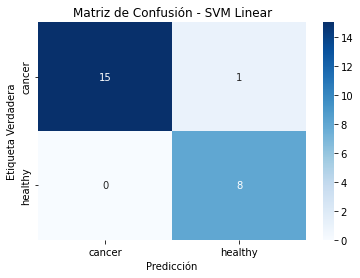

Modelo: SVM RBF, Accuracy: 0.9583333333333334, F1 Score: 0.9588867805186592, MCC: 0.9128709291752769
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.94      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24

Matriz de confusión para SVM RBF:
[[15  1]
 [ 0  8]]


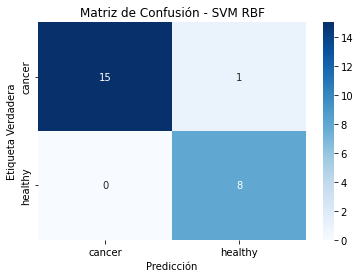

Modelo: Logistic Regression, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matriz de confusión para Logistic Regression:
[[16  0]
 [ 0  8]]


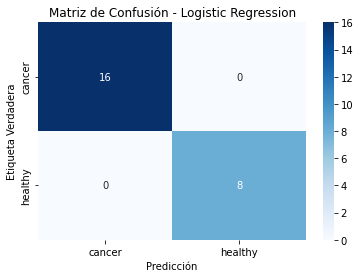

Modelo: Random Forest, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matriz de confusión para Random Forest:
[[16  0]
 [ 0  8]]


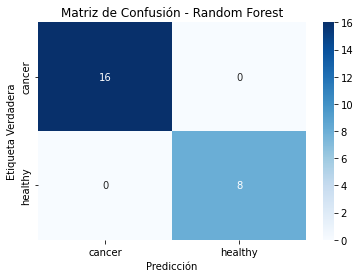

Modelo: Boosting, Accuracy: 0.9583333333333334, F1 Score: 0.9575757575757576, MCC: 0.9074852129730302
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.88      0.93         8

    accuracy                           0.96        24
   macro avg       0.97      0.94      0.95        24
weighted avg       0.96      0.96      0.96        24

Matriz de confusión para Boosting:
[[16  0]
 [ 1  7]]


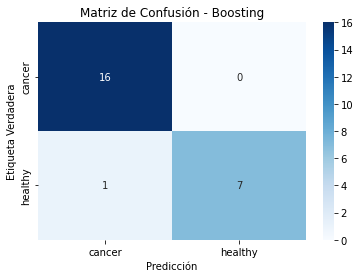

Modelo: Neural Network, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Matriz de confusión para Neural Network:
[[16  0]
 [ 0  8]]


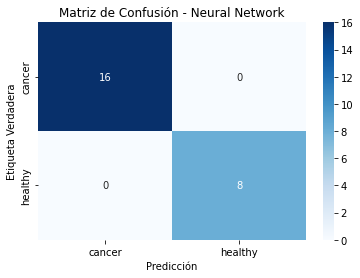


Mejores Hiperparámetros:
Mejores hiperparámetros para SVM Linear: {'svm_linear__C': 0.01}
Mejores hiperparámetros para SVM RBF: {'svm_rbf__C': 0.1, 'svm_rbf__gamma': 0.1}
Mejores hiperparámetros para Logistic Regression: {'logistic_regression__C': 1e-05, 'logistic_regression__penalty': 'l2'}
Mejores hiperparámetros para Random Forest: {'random_forest__max_depth': None, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 20}
Mejores hiperparámetros para Boosting: {'boosting__learning_rate': 1, 'boosting__n_estimators': 30}
Modelo: SVM Linear, Accuracy: 0.9583333333333334, F1 Score: 0.9588867805186592, MCC: 0.9128709291752769
Modelo: SVM RBF, Accuracy: 0.9583333333333334, F1 Score: 0.9588867805186592, MCC: 0.9128709291752769
Modelo: Logistic Regression, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0
Modelo: Random Forest, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0
Modelo: Boosting, Accuracy: 0.9583333333333334, F1 Score: 0.9575757575757576, MCC: 0.9074852129730302
Modelo: Neural N

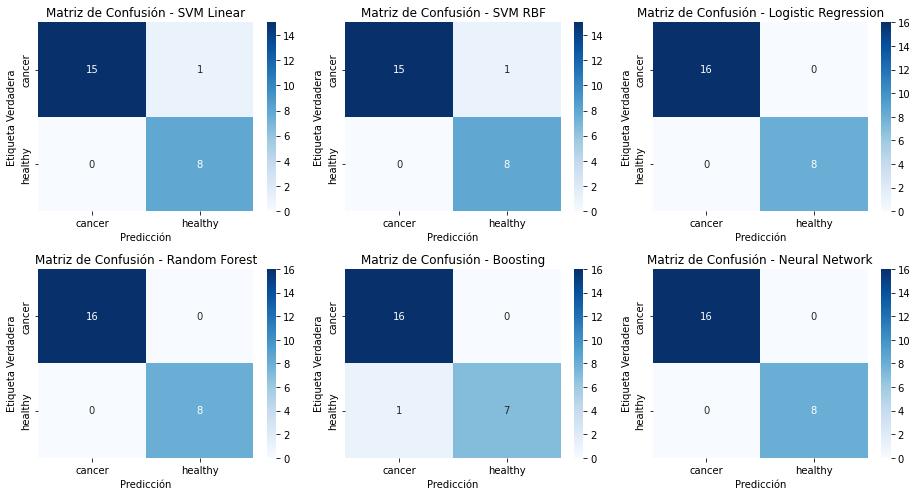

In [89]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

# Entrenar los modelos finales
final_models = {}
for name, clf_info in classifiers.items():
    model = clf_info['model']
    # Obtener los mejores hiperparámetros
    param_counts = Counter(tuple(sorted(params.items())) for params in best_params[name])
    most_common_params = dict(param_counts.most_common(1)[0][0])

    # Crear pipeline con el modelo
    pipeline = Pipeline([
        (name.lower().replace(' ', '_'), model)
    ])

    # Establecer los hiperparámetros utilizando los nombres completos
    pipeline.set_params(**most_common_params)
    pipeline.fit(X_train, y_train)
    final_models[name] = pipeline
    # Guardar el modelo
    joblib.dump(pipeline, f'final_{name.lower().replace(" ", "_")}_model.pkl')

# Entrenar el modelo final de la Red Neuronal
clear_session()
mlp = MLP(nb_input=X_train.shape[1])
opt = SGD(learning_rate=0.001, momentum=0.9)  # Usar el optimizador legacy
mlp.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
Y_train_encoded = to_categorical(y_train, num_classes=2)
mlp.fit(X_train, Y_train_encoded, batch_size=16, epochs=100, verbose=0)
mlp.save('final_neural_network_model')
final_models['Neural Network'] = mlp

# Realizar predicciones y calcular métricas en el conjunto de prueba
predictions = {}
for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        y_pred = model.predict(X_test)
    predictions[name] = y_pred

# **Análisis de Resultados**
print("Análisis de Resultados en el Conjunto de Prueba:")
for name, y_pred in predictions.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Modelo: {name}, Accuracy: {acc}, F1 Score: {f1}, MCC: {mcc}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    
    # Mostrar la matriz de confusión
    print(f"Matriz de confusión para {name}:")
    print(cm)
    
    # Visualizar la matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()

# Analizar los mejores hiperparámetros
print("\nMejores Hiperparámetros:")
for name, params_list in best_params.items():
    param_counts = Counter(tuple(sorted(params.items())) for params in params_list)
    most_common_params = dict(param_counts.most_common(1)[0][0])
    print(f"Mejores hiperparámetros para {name}: {most_common_params}")

#imprime las metricas 
for name, y_pred in predictions.items():
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Modelo: {name}, Accuracy: {acc}, F1 Score: {f1}, MCC: {mcc}")

# Crear una figura para las matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(13, 7))  # Ajusta el tamaño según sea necesario
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[idx])
    axes[idx].set_title(f'Matriz de Confusión - {name}')
    axes[idx].set_xlabel('Predicción')
    axes[idx].set_ylabel('Etiqueta Verdadera')

# Ajustar el layout y guardar la imagen
plt.tight_layout()
plt.savefig('matrices_de_confusion.jpg')
plt.show()

In [90]:
# Entrenar los modelos finales
import os
final_models = {}
for name, clf_info in classifiers.items():
    model = clf_info['model']
    # Obtener los mejores hiperparámetros
    param_counts = Counter(tuple(sorted(params.items())) for params in best_params[name])
    most_common_params = dict(param_counts.most_common(1)[0][0])

    # Crear pipeline con el modelo
    pipeline = Pipeline([
        (name.lower().replace(' ', '_'), model)
    ])

    # Establecer los hiperparámetros utilizando los nombres completos
    pipeline.set_params(**most_common_params)
    pipeline.fit(X_final, y_encoded)
    final_models[name] = pipeline
    # Guardar el modelo
    joblib.dump(pipeline, f'final_{name.lower().replace(" ", "_")}_model.pkl')

# Entrenar el modelo final de la Red Neuronal
clear_session()
mlp = MLP(nb_input=X_final.shape[1])
opt = SGD(learning_rate=0.001, momentum=0.9) 
mlp.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
Y_encoded = to_categorical(y_encoded, num_classes=2)
mlp.fit(X_final, Y_encoded, batch_size=16, epochs=100, verbose=0)
mlp.save('final_neural_network_model')
final_models['Neural Network'] = mlp


INFO:tensorflow:Assets written to: final_neural_network_model/assets


INFO:tensorflow:Assets written to: final_neural_network_model/assets


In [91]:
predictions = {}
for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred = np.argmax(model.predict(X_final), axis=1)
    else:
        y_pred = model.predict(X_final)
    predictions[name] = y_pred

for name, model in final_models.items():
    print(f"Evaluación del modelo {name} en el conjunto reservado:")
    if name == 'Neural Network':
        y_pred_reserved = np.argmax(model.predict(X_final), axis=1)
    else:
        y_pred_reserved = model.predict(X_final)
    print(classification_report(y_pred, y_pred_reserved))
    mcc_reserved = matthews_corrcoef(y_pred, y_pred_reserved)
    print(f"MCC (Matthews Correlation Coefficient) para {name}: {mcc_reserved:.3f}")

4/4 [==============================] - 0s 892us/step
Evaluación del modelo SVM Linear en el conjunto reservado:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        70
           1       0.98      1.00      0.99        50

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

MCC (Matthews Correlation Coefficient) para SVM Linear: 0.983
Evaluación del modelo SVM RBF en el conjunto reservado:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        70
           1       0.98      1.00      0.99        50

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

MCC (Matthews Correlation Coefficient) para SVM RBF: 0.983
Evaluación del modelo Logistic Regression en el conjunto 

In [92]:
predictions = {}
for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred = np.argmax(model.predict(X_final), axis=1)
    else:
        y_pred = model.predict(X_final)
    predictions[name] = y_pred

# **Análisis de Resultados**
print("Análisis de Resultados:")
for name, y_pred in predictions.items():
    acc = accuracy_score(y_encoded, y_pred)
    f1 = f1_score(y_encoded, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_encoded, y_pred)
    roc_auc = roc_auc_score(y_encoded, y_pred)
    print(f"Modelo: {name}, Accuracy: {acc}, F1 Score: {f1}, MCC: {mcc}, ROC AUC: {roc_auc}")

# Analizar los mejores hiperparámetros
print("\nMejores Hiperparámetros:")
for name, params_list in best_params.items():
    param_counts = Counter(tuple(sorted(params.items())) for params in params_list)
    most_common_params = dict(param_counts.most_common(1)[0][0])
    print(f"Mejores hiperparámetros para {name}: {most_common_params}")

4/4 [==============================] - 0s 744us/step
Análisis de Resultados:
Modelo: SVM Linear, Accuracy: 0.9916666666666667, F1 Score: 0.9916779447728946, MCC: 0.9830496196132974, ROC AUC: 0.9928571428571429
Modelo: SVM RBF, Accuracy: 0.9916666666666667, F1 Score: 0.9916779447728946, MCC: 0.9830496196132974, ROC AUC: 0.9928571428571429
Modelo: Logistic Regression, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0, ROC AUC: 1.0
Modelo: Random Forest, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0, ROC AUC: 1.0
Modelo: Boosting, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0, ROC AUC: 1.0
Modelo: Neural Network, Accuracy: 1.0, F1 Score: 1.0, MCC: 1.0, ROC AUC: 1.0

Mejores Hiperparámetros:
Mejores hiperparámetros para SVM Linear: {'svm_linear__C': 0.01}
Mejores hiperparámetros para SVM RBF: {'svm_rbf__C': 0.1, 'svm_rbf__gamma': 0.1}
Mejores hiperparámetros para Logistic Regression: {'logistic_regression__C': 1e-05, 'logistic_regression__penalty': 'l2'}
Mejores hiperparámetros para Random Forest: {'random_forest_

Evaluación del modelo SVM Linear en el conjunto reservado:
Modelo: SVM Linear, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        39
           1       0.00      0.00      0.00        30

    accuracy                           0.57        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.32      0.57      0.41        69

Matriz de confusión para SVM Linear:
[[39  0]
 [30  0]]


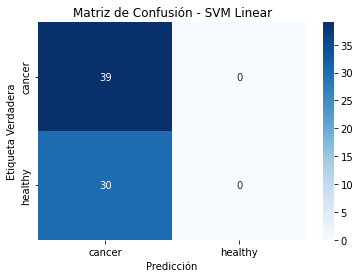

Evaluación del modelo SVM RBF en el conjunto reservado:
Modelo: SVM RBF, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        39
           1       0.00      0.00      0.00        30

    accuracy                           0.57        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.32      0.57      0.41        69

Matriz de confusión para SVM RBF:
[[39  0]
 [30  0]]


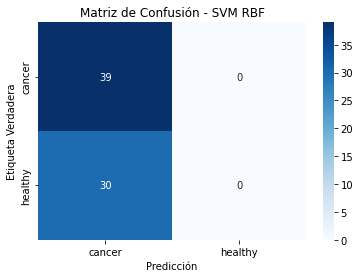

Evaluación del modelo Logistic Regression en el conjunto reservado:
Modelo: Logistic Regression, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        39
           1       0.00      0.00      0.00        30

    accuracy                           0.57        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.32      0.57      0.41        69

Matriz de confusión para Logistic Regression:
[[39  0]
 [30  0]]


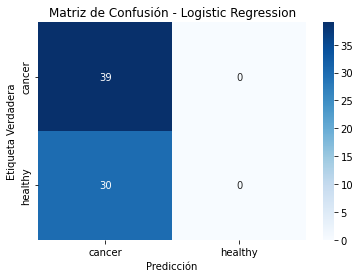

Evaluación del modelo Random Forest en el conjunto reservado:
Modelo: Random Forest, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        39
           1       0.00      0.00      0.00        30

    accuracy                           0.57        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.32      0.57      0.41        69

Matriz de confusión para Random Forest:
[[39  0]
 [30  0]]


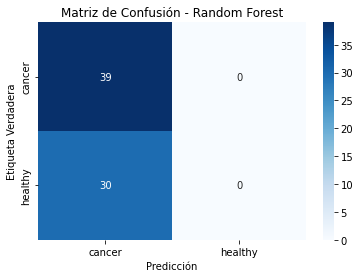

Evaluación del modelo Boosting en el conjunto reservado:
Modelo: Boosting, Accuracy: 0.5797101449275363, F1 Score: 0.4400781219278814, MCC: 0.13826657968874304
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        39
           1       1.00      0.03      0.06        30

    accuracy                           0.58        69
   macro avg       0.79      0.52      0.40        69
weighted avg       0.76      0.58      0.44        69

Matriz de confusión para Boosting:
[[39  0]
 [29  1]]


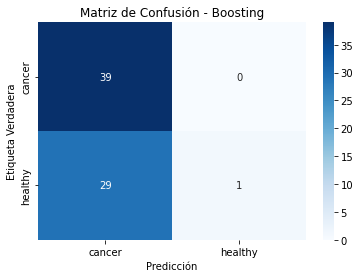

Evaluación del modelo Neural Network en el conjunto reservado:
3/3 [==============================] - 0s 1ms/step
Modelo: Neural Network, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        39
           1       0.00      0.00      0.00        30

    accuracy                           0.57        69
   macro avg       0.28      0.50      0.36        69
weighted avg       0.32      0.57      0.41        69

Matriz de confusión para Neural Network:
[[39  0]
 [30  0]]


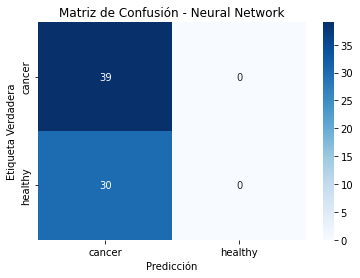

Modelo: SVM Linear, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
Modelo: SVM RBF, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
Modelo: Logistic Regression, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
Modelo: Random Forest, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0
Modelo: Boosting, Accuracy: 0.5797101449275363, F1 Score: 0.4400781219278814, MCC: 0.13826657968874304
3/3 [==============================] - 0s 1ms/step
Modelo: Neural Network, Accuracy: 0.5652173913043478, F1 Score: 0.40821256038647347, MCC: 0.0


In [93]:
# **Evaluación en el Conjunto Reservado**

# Preprocesar el conjunto reservado
#X_reserved = microarray_data_common.drop('labels', axis=1)
#y_reserved = microarray_data_common['labels']
#y_reserved_encoded = label_encoder.transform(y_reserved)

X_reserved = microarray_corrected.drop('labels', axis=1)
y_reserved = microarray_corrected['labels']
y_reserved_encoded = label_encoder.transform(y_reserved)
# Escalar las características
X_reserved_scaled = min_max_scaler.transform(X_reserved)
X_reserved_scaled = pd.DataFrame(X_reserved_scaled, columns=X_reserved.columns)

# Selección de características
X_reserved_mi = X_reserved_scaled.iloc[:, selected_scores_indices]
X_reserved_final = rfe.transform(X_reserved_mi)
#X_reserved_final = selection.transform(X_reserved_selected)

#X_reserved_final = pca.transform(X_reserved_final_1)

# Evaluar los modelos
for name, model in final_models.items():
    print(f"Evaluación del modelo {name} en el conjunto reservado:")
    if name == 'Neural Network':
        y_pred_reserved = np.argmax(model.predict(X_reserved_final), axis=1)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")
    print(classification_report(y_reserved_encoded, y_pred_reserved))
    
    # Calcular la matriz de confusión
    cm_reserved = confusion_matrix(y_reserved_encoded, y_pred_reserved)
    
    # Mostrar la matriz de confusión
    print(f"Matriz de confusión para {name}:")
    print(cm_reserved)
    
    # Visualizar la matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_reserved, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred_reserved = np.argmax(model.predict(X_reserved_final), axis=1)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")


In [94]:
# Importar las librerías necesarias
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pandas as pd

# Suponiendo que ya tienes:
# X: tus características originales (no escaladas)
# y_encoded: tus etiquetas codificadas
# predictions: diccionario con las predicciones de tus modelos
# y_true: etiquetas verdaderas obtenidas durante la validación cruzada
# best_params: diccionario con los mejores hiperparámetros de tus modelos

# Configurar la validación cruzada K-Folds con 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# Crear el pipeline que incluye el escalado y el predictor aleatorio
pipeline_dummy = make_pipeline(
    StandardScaler(),
    DummyClassifier(strategy='uniform', random_state=seed)
)

# Evaluar el predictor aleatorio con cross_val_score
scores_dummy = cross_val_score(pipeline_dummy, X_reserved_final, y_reserved_encoded, cv=kf, scoring='accuracy')
print(f"Precisión promedio del predictor aleatorio: {scores_dummy.mean():.4f}")

# Obtener predicciones con cross_val_predict
y_pred_dummy = cross_val_predict(pipeline_dummy, X_reserved_final, y_reserved_encoded, cv=kf)

# Calcular y mostrar las métricas para el predictor aleatorio
print("\nReporte de clasificación del predictor aleatorio:")
print(classification_report(y_reserved_encoded, y_pred_dummy))

acc_dummy = accuracy_score(y_reserved_encoded, y_pred_dummy)
f1_dummy = f1_score(y_reserved_encoded, y_pred_dummy, average='weighted')
mcc_dummy = matthews_corrcoef(y_reserved_encoded, y_pred_dummy)
print(f"Predictor Aleatorio - Accuracy: {acc_dummy:.4f}, F1 Score: {f1_dummy:.4f}, MCC: {mcc_dummy:.4f}")

Precisión promedio del predictor aleatorio: 0.2190

Reporte de clasificación del predictor aleatorio:
              precision    recall  f1-score   support

           0       0.31      0.31      0.31        39
           1       0.10      0.10      0.10        30

    accuracy                           0.22        69
   macro avg       0.20      0.20      0.20        69
weighted avg       0.22      0.22      0.22        69

Predictor Aleatorio - Accuracy: 0.2174, F1 Score: 0.2174, MCC: -0.5923


In [95]:
#haz una matriz de confusion
cm_reserved_dummy = confusion_matrix(y_reserved_encoded, y_pred_dummy)

In [96]:
# Mostrar la matriz de confusión
print("Matriz de confusión para el predictor aleatorio:")
print(cm_reserved_dummy)

Matriz de confusión para el predictor aleatorio:
[[12 27]
 [27  3]]


In [97]:
# Importar las librerías necesarias
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pandas as pd

# Suponiendo que ya tienes:
# X: tus características originales (no escaladas)
# y_encoded: tus etiquetas codificadas
# predictions: diccionario con las predicciones de tus modelos
# y_true: etiquetas verdaderas obtenidas durante la validación cruzada
# best_params: diccionario con los mejores hiperparámetros de tus modelos

# Configurar la validación cruzada K-Folds con 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Crear el pipeline que incluye el escalado y el predictor aleatorio
pipeline_dummy = make_pipeline(
    StandardScaler(),
    DummyClassifier(strategy='uniform', random_state=42)
)

# Evaluar el predictor aleatorio con cross_val_score
scores_dummy = cross_val_score(pipeline_dummy, X_reserved_final, y_reserved_encoded, cv=kf, scoring='accuracy')
print(f"Precisión promedio del predictor aleatorio: {scores_dummy.mean():.4f}")

# Obtener predicciones con cross_val_predict
y_pred_dummy = cross_val_predict(pipeline_dummy, X_reserved_final, y_reserved_encoded, cv=kf)

# Calcular y mostrar las métricas para el predictor aleatorio
print("\nReporte de clasificación del predictor aleatorio:")
print(classification_report(y_reserved_encoded, y_pred_dummy))

acc_dummy = accuracy_score(y_reserved_encoded, y_pred_dummy)
f1_dummy = f1_score(y_reserved_encoded, y_pred_dummy, average='weighted')
mcc_dummy = matthews_corrcoef(y_reserved_encoded, y_pred_dummy)
print(f"Predictor Aleatorio - Accuracy: {acc_dummy:.4f}, F1 Score: {f1_dummy:.4f}, MCC: {mcc_dummy:.4f}")

# Evaluar tus modelos y almacenar las métricas
metrics = {}

for name in predictions.keys():
    y_pred = predictions[name]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    metrics[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'MCC': mcc
    }
    print(f"{name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, MCC: {mcc:.4f}")

# Añadir las métricas del predictor aleatorio al diccionario
metrics['Predictor Aleatorio'] = {
    'Accuracy': acc_dummy,
    'F1 Score': f1_dummy,
    'MCC': mcc_dummy
}

# Mostrar las métricas en una tabla
metrics_df = pd.DataFrame(metrics).T  # Transponer para que los modelos sean las filas
print("\nComparación de métricas:")
print(metrics_df)

# Analizar los mejores hiperparámetros
print("\nMejores hiperparámetros para cada modelo:")
for name, params_list in best_params.items():
    param_counts = Counter(tuple(sorted(params.items())) for params in params_list)
    most_common_params = dict(param_counts.most_common(1)[0][0])
    print(f"{name}: {most_common_params}")

Precisión promedio del predictor aleatorio: 0.5667

Reporte de clasificación del predictor aleatorio:
              precision    recall  f1-score   support

           0       0.59      0.74      0.66        39
           1       0.50      0.33      0.40        30

    accuracy                           0.57        69
   macro avg       0.55      0.54      0.53        69
weighted avg       0.55      0.57      0.55        69

Predictor Aleatorio - Accuracy: 0.5652, F1 Score: 0.5464, MCC: 0.0840


ValueError: Found input variables with inconsistent numbers of samples: [10, 120]

In [ ]:
# Importar las librerías necesarias
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pandas as pd

# Suponiendo que ya tienes:
# X: tus características originales (no escaladas)
# y_encoded: tus etiquetas codificadas
# predictions: diccionario con las predicciones de tus modelos
# y_true: etiquetas verdaderas obtenidas durante la validación cruzada
# best_params: diccionario con los mejores hiperparámetros de tus modelos

# Configurar la validación cruzada K-Folds con 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Crear el pipeline que incluye el escalado y el predictor aleatorio
pipeline_dummy = make_pipeline(
    StandardScaler(),
    DummyClassifier(strategy='uniform', random_state=42)
)

# Evaluar el predictor aleatorio con cross_val_score
scores_dummy = cross_val_score(pipeline_dummy, X, y_encoded, cv=kf, scoring='accuracy')
print(f"Precisión promedio del predictor aleatorio: {scores_dummy.mean():.4f}")

# Obtener predicciones con cross_val_predict
y_pred_dummy = cross_val_predict(pipeline_dummy, X, y_encoded, cv=kf)

# Calcular y mostrar las métricas para el predictor aleatorio
print("\nReporte de clasificación del predictor aleatorio:")
print(classification_report(y_encoded, y_pred_dummy))

acc_dummy = accuracy_score(y_encoded, y_pred_dummy)
f1_dummy = f1_score(y_encoded, y_pred_dummy, average='weighted')
mcc_dummy = matthews_corrcoef(y_encoded, y_pred_dummy)
print(f"Predictor Aleatorio - Accuracy: {acc_dummy:.4f}, F1 Score: {f1_dummy:.4f}, MCC: {mcc_dummy:.4f}")

# Evaluar tus modelos y almacenar las métricas
metrics = {}

for name in predictions.keys():
    y_pred = predictions[name]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    metrics[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'MCC': mcc
    }
    print(f"{name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, MCC: {mcc:.4f}")

# Añadir las métricas del predictor aleatorio al diccionario
metrics['Predictor Aleatorio'] = {
    'Accuracy': acc_dummy,
    'F1 Score': f1_dummy,
    'MCC': mcc_dummy
}

# Mostrar las métricas en una tabla
metrics_df = pd.DataFrame(metrics).T  # Transponer para que los modelos sean las filas
print("\nComparación de métricas:")
print(metrics_df)

# Analizar los mejores hiperparámetros
print("\nMejores hiperparámetros para cada modelo:")
for name, params_list in best_params.items():
    param_counts = Counter(tuple(sorted(params.items())) for params in params_list)
    most_common_params = dict(param_counts.most_common(1)[0][0])
    print(f"{name}: {most_common_params}")

In [ ]:
# Importar las librerías necesarias
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pandas as pd

# Suponiendo que ya tienes:
# X: tus características originales (no escaladas)
# y_encoded: tus etiquetas codificadas
# best_params: diccionario con los mejores hiperparámetros de tus modelos
# final_models: diccionario con los modelos finales entrenados

# Configurar la validación cruzada K-Folds con 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Crear el pipeline que incluye el escalado y el predictor aleatorio
pipeline_dummy = make_pipeline(
    StandardScaler(),
    DummyClassifier(strategy='uniform', random_state=42)
)

# Evaluar el predictor aleatorio con cross_val_score
scores_dummy = cross_val_score(pipeline_dummy, X, y_encoded, cv=kf, scoring='accuracy')
print(f"Precisión promedio del predictor aleatorio: {scores_dummy.mean():.4f}")

# Obtener predicciones con cross_val_predict
y_pred_dummy = cross_val_predict(pipeline_dummy, X, y_encoded, cv=kf)

# Calcular y mostrar las métricas para el predictor aleatorio
print("\nReporte de clasificación del predictor aleatorio:")
print(classification_report(y_encoded, y_pred_dummy))

acc_dummy = accuracy_score(y_encoded, y_pred_dummy)
f1_dummy = f1_score(y_encoded, y_pred_dummy, average='weighted')
mcc_dummy = matthews_corrcoef(y_encoded, y_pred_dummy)
print(f"Predictor Aleatorio - Accuracy: {acc_dummy:.4f}, F1 Score: {f1_dummy:.4f}, MCC: {mcc_dummy:.4f}")
